# Online non-linear regression with corrupted observations

In [50]:
import jax
import numpy as np
import pandas as pd
import seaborn as sns
import flax.linen as nn
import jax.numpy as jnp
import matplotlib.pyplot as plt

from bayes_opt import BayesianOptimization
from functools import partial
from rebayes_mini import callbacks
from rebayes_mini.methods import gauss_filter as gf
from rebayes_mini.methods import robust_filter as rfilter
from rebayes_mini.methods import generalised_bayes_filter as gbfilter

In [2]:
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = "retina"

plt.rcParams["font.size"] = 18

cmap = {
    "Robust EKF": "crimson",
    "IMQF": "dodgerblue",
    "EKF": "lightseagreen"
}

## Data-generating process

In [52]:
def f(x):
    return x / 5 - 10 * jnp.cos(jnp.pi * x) + x ** 3


def sample_observations_grid(key, f, n_obs, xmin, xmax, x_noise=0.1, y_noise=3.0):
    key_x, key_y, key_shuffle, key_corrupted = jax.random.split(key, 4)
    
    key_cchoice, key_cval = jax.random.split(key_corrupted)
    is_corrupted = jax.random.bernoulli(key_cchoice, p=0.05, shape=(n_obs,))
    ycorr = jax.random.uniform(key_cval, (n_obs,), minval=-50, maxval=50)
    
    y_noise = jax.random.normal(key_y, (n_obs,)) * y_noise
    x = jax.random.uniform(key_x, (n_obs,), minval=-3, maxval=3)
    y = f(x) + y_noise
    
    y = y * (1 - is_corrupted) + ycorr * is_corrupted
    
    X = jnp.c_[x, y]
    shuffled_ixs = jax.random.permutation(key_shuffle, jnp.arange(n_obs))
    x, y = jnp.array(X[shuffled_ixs, :].T)
    
    return x, y



def sample_observations_one_sided(key, f, n_obs, xmin, xmax, x_noise=0.1, y_noise=3.0):
    key_x, key_y, key_shuffle, key_corrupted = jax.random.split(key, 4)
    
    is_corrupted = jax.random.bernoulli(key_corrupted, p=0.05, shape=(n_obs,))
        
    x_noise = jax.random.normal(key_x, (n_obs,)) * x_noise
    y_noise = jax.random.normal(key_y, (n_obs,)) * y_noise
    x = jnp.linspace(xmin, xmax, n_obs) + x_noise
    y = f(x) + y_noise
    
    y = y * (1 - is_corrupted) + is_corrupted * 50.0
    
    X = jnp.c_[x, y]
    shuffled_ixs = jax.random.permutation(key_shuffle, jnp.arange(n_obs))
    x, y = jnp.array(X[shuffled_ixs, :].T)
    
    return x, y

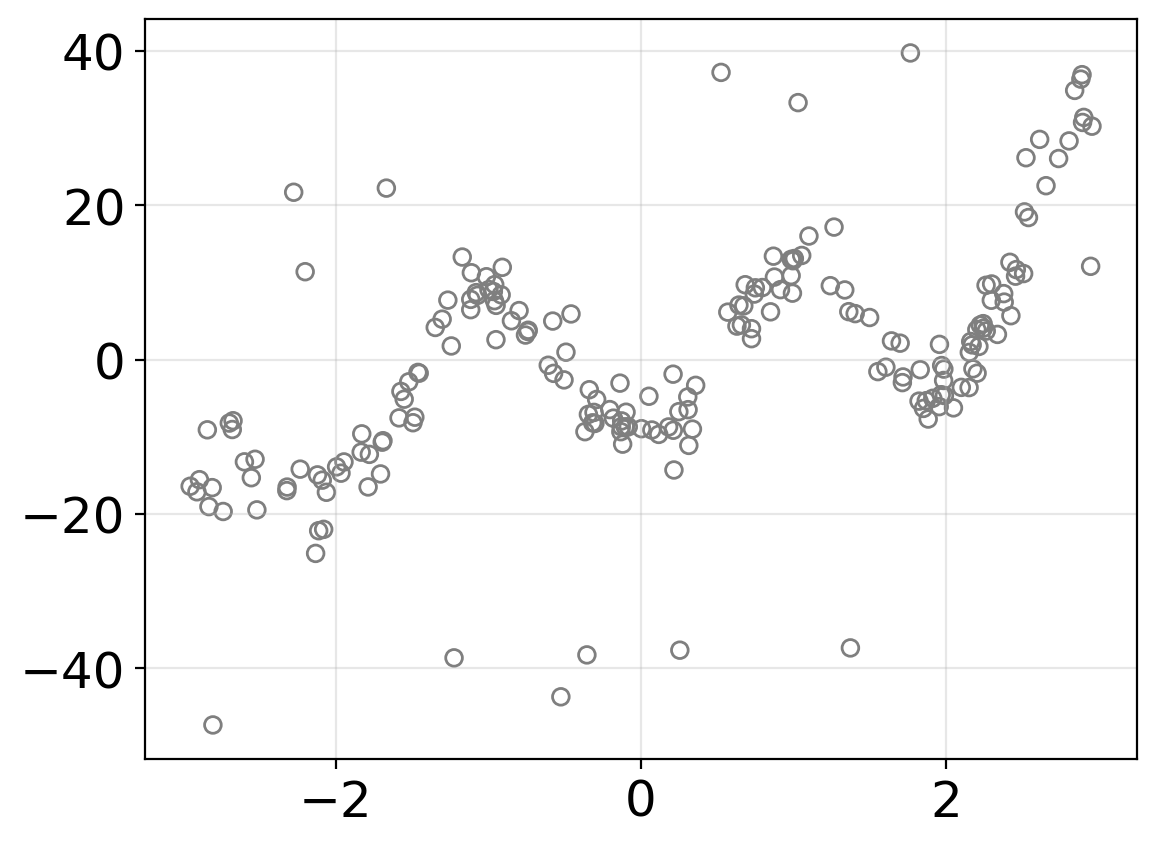

In [4]:
key = jax.random.PRNGKey(31)
key_train, key_sample_obs, key_eval = jax.random.split(key, 3)

n_obs = 200
xmin, xmax = -3, 3
sigma_y = 3.0
x, y = sample_observations_grid(key_sample_obs, f, n_obs, xmin, xmax, x_noise=0.1, y_noise=sigma_y)
xtest = jnp.linspace(x.min(), x.max(), n_obs)
plt.scatter(x, y, edgecolors="tab:gray", color="none")
plt.grid(alpha=0.3)

## Filtering

In [3]:
def callback_fn(bel, bel_pred, y, x, applyfn):
    yhat = applyfn(bel_pred.mean, x[None])
    return yhat - y

In [75]:
class MLP(nn.Module):
    @nn.compact
    def __call__(self, x):
        x = nn.Dense(10)(x)
        x = jnp.sin(x)
        x = nn.Dense(10)(x)
        x = nn.relu(x)
        x = nn.Dense(1)(x)
        return x

def latent_fn(x): return x

model = MLP()

### Setup
Parameters shared for all methods

In [74]:
dynamics_covariance = 1e-4
observation_covariance = 1.0

cov_init = 1.0
params_init = model.init(key_train, x[:, None])

### Extended Kalman Filter

In [76]:
agent_ekf = gf.ExtendedKalmanFilter(
    latent_fn, model.apply, dynamics_covariance=dynamics_covariance,
    observation_covariance=observation_covariance * jnp.eye(1)
    
)

bel_init = agent_ekf.init_bel(params_init, cov=1.0)
bel_ekf, hist_bel_ekf = agent_ekf.scan(bel_init, y, x[:, None])
yhat_ekf = agent_ekf.vobs_fn(bel_ekf.mean, xtest[:, None]).ravel()

### Robust Extended Kalman Filter

In [77]:
noise_scaling = 6.0

agent_rekf = rfilter.ExtendedRobustKalmanFilter(
    latent_fn, model.apply, dynamics_covariance=dynamics_covariance,
    prior_observation_covariance=observation_covariance * jnp.eye(1),
    noise_scaling=noise_scaling,
    n_inner=1
)

bel_init = agent_rekf.init_bel(params_init, cov=1.0)
bel_rekf, hist_bel_rekf = agent_rekf.scan(bel_init, y, x[:, None])
yhat_rekf = agent_rekf.vobs_fn(bel_rekf.mean, xtest[:, None]).ravel()

### Inverse Multi-quadratic filter

In [79]:
soft_threshold = 3.0
agent_imq = gbfilter.IMQFilter(
    model.apply, dynamics_covariance=dynamics_covariance,
    observation_covariance=observation_covariance,
    soft_threshold=soft_threshold
)

bel_init = agent_imq.init_bel(params_init, cov=1.0)
bel_imq, hist_bel_imq = agent_imq.scan(bel_init, y, x[:, None])
yhat_imq = agent_imq.link_fn(bel_imq.mean, xtest[:, None]).ravel()

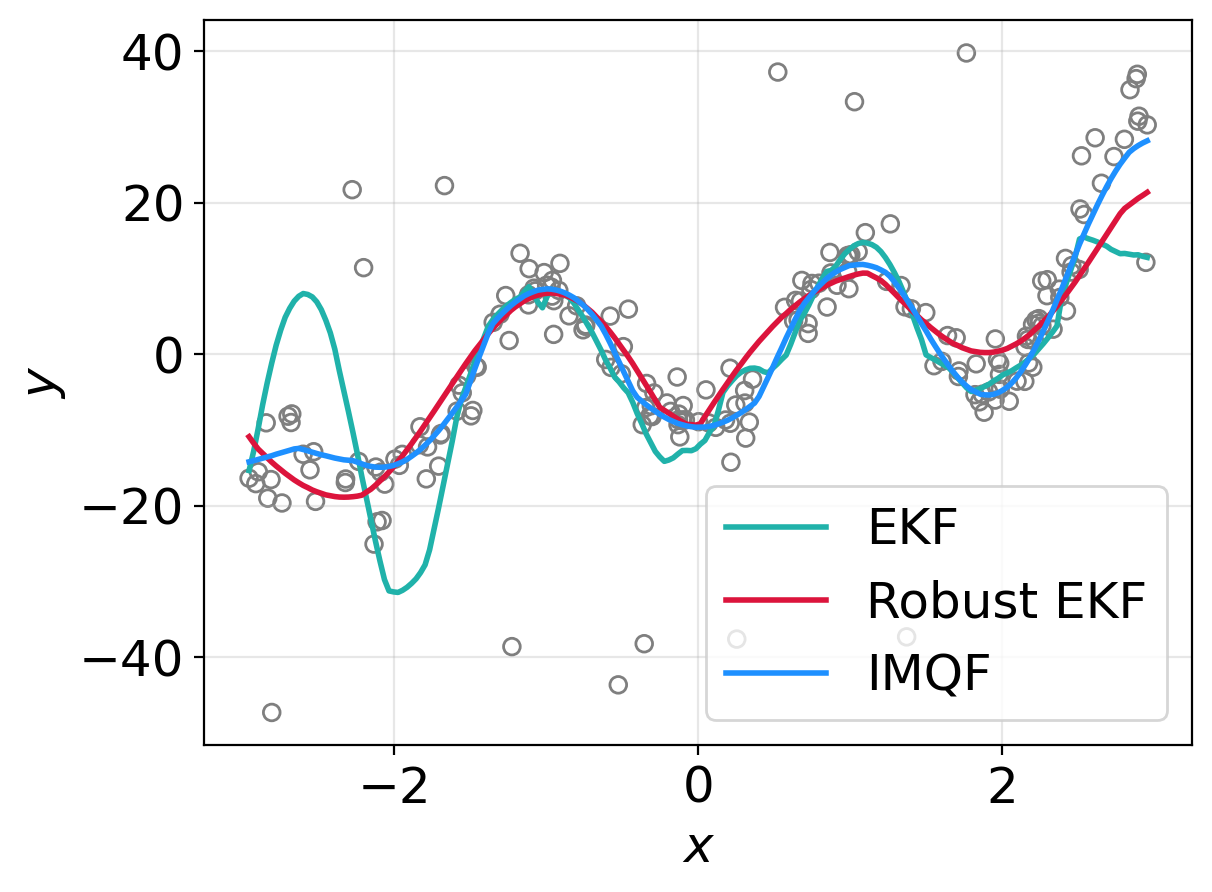

In [80]:
plt.scatter(x, y, edgecolors="tab:gray", c="none")
plt.plot(xtest, yhat_ekf, c="lightseagreen", linewidth=2, label="EKF")
plt.plot(xtest, yhat_rekf, c="crimson", linewidth=2, label="Robust EKF")
plt.plot(xtest, yhat_imq, c="dodgerblue", linewidth=2, label="IMQF")
plt.grid(alpha=0.3)
plt.ylabel("$y$")
plt.xlabel("$x$")
plt.legend()
plt.tight_layout()
plt.savefig("./figures/online-mlp-sample.pdf")

## Multiple runs

In [60]:
ytest = f(xtest)

@partial(jax.vmap)
@jax.jit
def sample_and_eval(key):
    key_train, key_sample_obs, key_eval = jax.random.split(key, 3)
    x, y = sample_observations_grid(key_sample_obs, f, n_obs, xmin, xmax, x_noise=0.1, y_noise=sigma_y)
    params_init = model.init(key_train, x[:, None])
    
    bel_init = agent_ekf.init_bel(params_init, cov=1.0)
    callback = partial(callback_fn, applyfn=agent_ekf.vobs_fn)
    bel_ekf, ekf_hist = agent_ekf.scan(bel_init, y, x[:, None], callback_fn=callback)
    yhat_ekf = agent_ekf.vobs_fn(bel_ekf.mean, xtest[:, None]).ravel()
    
    bel_init = agent_rekf.init_bel(params_init, cov=1.0)
    callback = partial(callback_fn, applyfn=agent_rekf.vobs_fn)
    bel_rekf, rekf_hist = agent_rekf.scan(bel_init, y, x[:, None], callback_fn=callback)
    yhat_rekf = agent_rekf.vobs_fn(bel_rekf.mean, xtest[:, None]).ravel()

    bel_init = agent_imq.init_bel(params_init, cov=1.0)
    callback = partial(callback_fn, applyfn=agent_imq.link_fn)
    bel_imq, imq_hist = agent_imq.scan(bel_init, y, x[:, None], callback_fn=callback)
    yhat_imq = agent_imq.link_fn(bel_imq.mean, xtest[:, None]).ravel()

    errs = {
        "Robust EKF": yhat_rekf,
        "IMQF": yhat_imq,
        "EKF": yhat_ekf,
    }
    
    # One-step-ahead errosrs
    errs_osa = {
        "Robust EKF": rekf_hist,
        "IMQF": imq_hist,
        "EKF": ekf_hist,        
    }
    
    errs = jax.tree_map(lambda yhat: jnp.sqrt(jnp.power(yhat - ytest, 2).mean()), errs)
    
    return errs, errs_osa

In [61]:
%%time
n_sims = 100 # 150
key = jax.random.PRNGKey(314)
keys = jax.random.split(key, n_sims)
results, errs_osa = sample_and_eval(keys)
results = jax.tree_map(np.array, results)
errs_osa = jax.tree_map(lambda x: np.array(x.squeeze()), errs_osa)
results_df = pd.DataFrame(results)

CPU times: user 36.6 s, sys: 1.64 s, total: 38.3 s
Wall time: 24.9 s


In [62]:
def running_mean(errs):
    errs = errs[:, :]
    _, nsteps = errs.shape
    # return np.power(errs, 2).cumsum(axis=1) / np.arange(1, nsteps + 1)[None]
    return jnp.sqrt(np.power(errs, 2).cumsum(axis=1))

errs_rmean = jax.tree_map(running_mean, errs_osa)

/tmp/ipykernel_3151636/876890463.py:5: RuntimeWarning: overflow encountered in power
  return jnp.sqrt(np.power(errs, 2).cumsum(axis=1))


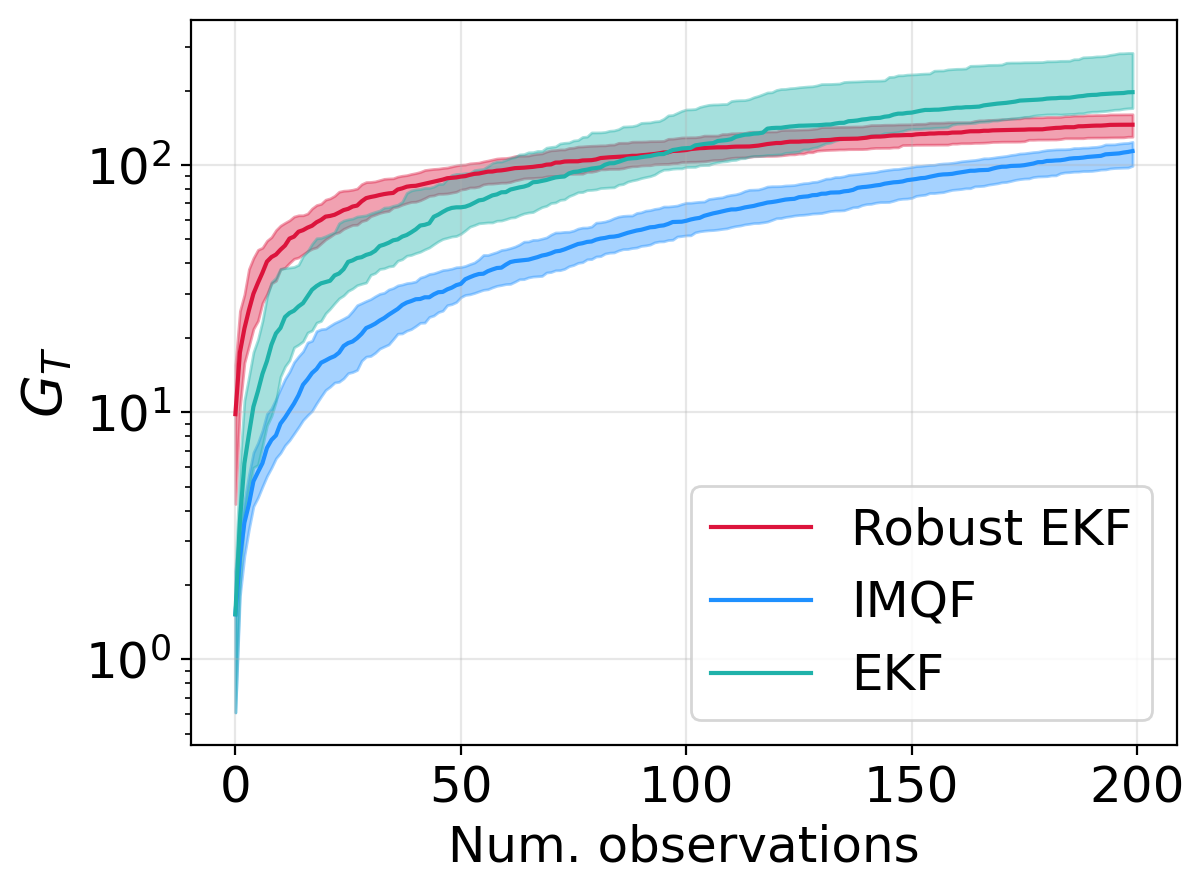

In [63]:
for method in cmap:
    plt.plot(np.nanquantile(errs_rmean[method], 0.5, axis=0), c=cmap[method], label=method)
    vmin, vmax = np.nanquantile(errs_rmean[method], [0.2, 0.8], axis=0)
    plt.fill_between(np.arange(len(vmin)), vmin, vmax, color=cmap[method], alpha=0.4)

plt.yscale("log")
plt.legend()
plt.grid(alpha=0.3)
plt.xlabel("Num. observations")
plt.ylabel("$G_T$", fontsize=20)
plt.tight_layout()
plt.savefig("./figures/online-mlp-osa-benchmark.pdf")

In [64]:
results_osa_df = jax.tree_map(lambda errs: jnp.sqrt(jnp.power(errs, 2).mean(axis=1)), errs_osa)
results_osa_df = pd.DataFrame(results_osa_df)
results_osa_df.describe()

,EKF,IMQF,Robust EKF
count,99.000000,100.000000,100.000000
mean,20.107027,7.900171,40.922802
std,38.598263,1.133343,306.562836
min,9.487157,5.258036,7.325858
25%,12.381474,7.062660,9.392591
50%,13.949293,8.057476,10.300180
75%,18.355900,8.513212,11.209072
max,395.751831,10.855614,3075.871094


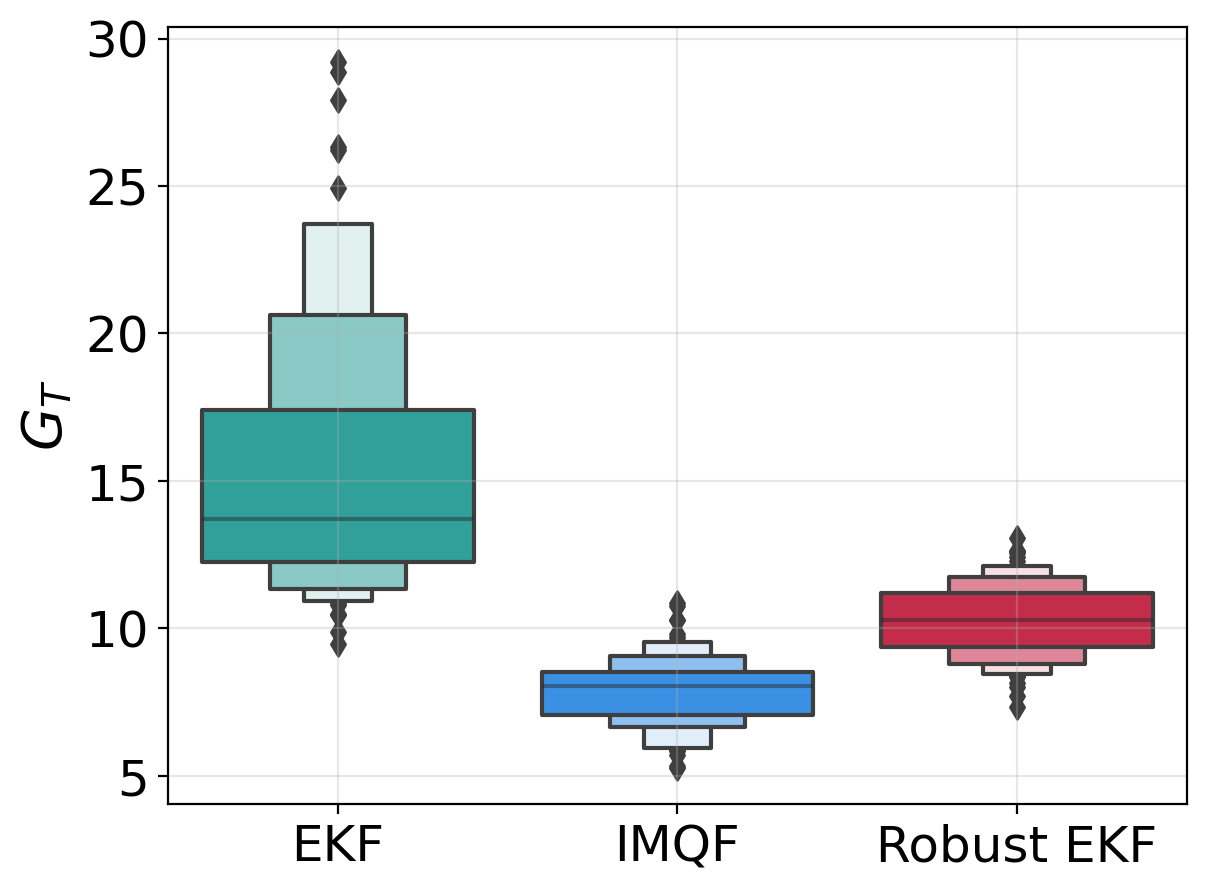

In [65]:
sns.boxenplot(
    results_osa_df.melt().query("value < 30"),
    x="variable", y="value",
    palette=cmap
)
plt.grid(alpha=0.3)
# plt.yscale("log")
plt.xlabel("")
plt.ylabel("$G_T$", fontsize=20)
plt.tight_layout()
plt.savefig("./figures/online-mlp-benchmark.pdf")